# MNIST Training using PyTorch

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/pytorch-mnist"

role = sagemaker.get_execution_role()

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms

#MNIST.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/"]

MNIST(
    "data",
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [4]:
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-west-2-414692569093/sagemaker/pytorch-mnist


In [7]:
#!pygmentize mnist.py

In [ ]:
#!pip install -U sagemaker

## Training
Using two m5.xlarge instance

In [5]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="mnist.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters={"epochs": 1, "backend": "gloo"},
)

In [6]:
estimator.fit({"training": inputs})

2023-03-26 23:45:38 Starting - Starting the training job...
2023-03-26 23:46:01 Starting - Preparing the instances for trainingProfilerReport-1679874338: InProgress
......
2023-03-26 23:46:49 Downloading - Downloading input data...
2023-03-26 23:47:29 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-26 19:48:18,753 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-26 19:48:18,755 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-26 19:48:18,757 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-03-26 19:48:18,767 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-26 19:48:18,769 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-26 19:48:18,981 sagemaker-trainin

### Deploy the model

In [7]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------!

In [8]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [15]:
import gzip
import numpy as np
import random
import os

data_dir = "data/MNIST/raw"
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16)  # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

In [16]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-6.92007629e+02 -8.58667419e+02 -4.58109192e+02 -9.49433838e+02
  -2.45842804e+02 -5.33714966e+02  0.00000000e+00 -9.55313660e+02
  -6.12962646e+02 -5.94613159e+02]
 [-6.90952942e+02 -8.85648499e+02 -5.92988159e+02 -8.10683105e+02
   0.00000000e+00 -6.13669800e+02 -4.26441833e+02 -5.60507507e+02
  -5.94960144e+02 -2.67328186e+02]
 [ 0.00000000e+00 -1.53703735e+03 -1.24948987e+03 -8.52752441e+02
  -1.40636182e+03 -5.63524170e+02 -1.18821082e+03 -8.95755493e+02
  -1.14392175e+03 -1.03526038e+03]
 [-2.96168152e+02 -5.84865295e+02 -2.36004211e+02 -5.28954834e+02
  -8.30700970e+00 -3.08618103e+02 -2.46851967e-04 -5.38549561e+02
  -2.75211121e+02 -2.68492706e+02]
 [-9.87589844e+02 -3.72522949e+02  0.00000000e+00 -1.89037689e+02
  -8.92218750e+02 -8.78373657e+02 -1.03888037e+03 -1.88026611e+02
  -4.82452118e+02 -5.25827209e+02]
 [-1.12420264e+03 -7.74543518e+02 -5.95776611e+02 -6.15061951e+02
  -5.88980530e+02 -1.01130615e+03 -1.23690381e+03  0.00000000e+00
  -6.31566

In [17]:
data.shape

(16, 28, 28)

#### Visualize End-point prediction

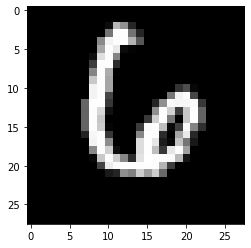

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(data[0, :, :], cmap="gray")

### Cleanup

In [19]:
sagemaker_session.delete_endpoint(endpoint_name=predictor.endpoint_name)